In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import os

## Marco teorico

La contaminación en Colombia se produce principalmente por dos causas, la primera se relaciona con la producción y tratamiento de combustibles fósiles para el sostenimiento de diferentes industrias y la segunda con el consumo de energía. 														     

Según el ministerio de ambiente y desarrollo, Colombia emite el 0.37% de los gases de efecto invernadero en el mundo. Posicionando al país en el puesto 137 en el rasquiña de países emisores de CO2 entre 184 países evaluados.														

El aumento de la temperatura planetaria provocada por los gases de efecto invernadero y la tala de bosques genera múltiples perjuicios a la humanidad: desórdenes del clima, tormentas tropicales, sequías, aumento y del nivel de los mares a causa del deshielo de los glaciares.																					   									
Colombia, más que por producir CO2, contribuye al calentamiento global con su enorme deforestación que provoca una serie de consecuencias catastróficas para toda la diversidad de nuestros bosque.

La NASA estima que el gradual aumento de las temperaturas que se registrará en el planeta en el transcurso de las próximas décadas provocará una serie de cambios significativos en el ecosistema, que, probablemete, se incrementen con el tiempo.

La temperatura promedio de la Tierra subió 2 grados Fahrenheit a lo largo del siglo XX y el fenómeno sigue manteniendo esa tendencia. Por eso, a futuro se preven incendios forestales más frecuentes, períodos de sequía más prolongados en algunas regiones y tormentas tropicales más intensas, numerosas y duraderas.

## Lectura y limpieza

In [4]:
temperaturas = pd.read_csv('data/temperaturasCol.csv', skiprows=2)
temperaturas.head()

,Unnamed: 0,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1901,24.84,25.01,25.30,25.06,24.55,23.90,23.94,24.17,24.23,24.27,24.33,24.34
1,1902,24.54,24.83,24.92,24.78,24.36,23.88,23.76,24.17,24.18,24.30,24.55,24.46
2,1903,24.54,25.00,25.01,24.75,24.37,23.91,23.94,24.17,24.42,24.28,24.35,24.29
3,1904,24.45,25.03,24.87,24.92,24.22,24.08,23.93,24.17,24.42,24.22,24.45,24.32
4,1905,24.43,24.69,24.83,24.79,24.19,23.84,23.94,24.17,24.42,24.34,24.45,24.25


In [5]:
nuevas_columnas = list(temperaturas.columns)
nuevas_columnas[0] = "Year"
temperaturas.columns = nuevas_columnas

In [6]:
temperaturas = temperaturas.melt(id_vars="Year")
temperaturas['date'] = temperaturas[['Year', 'variable']].apply(lambda x: str(x['Year']) + '-' + x['variable'],axis=1)
temperaturas['date'] = pd.to_datetime(temperaturas['date'])

In [7]:
temperaturas = temperaturas.sort_values(by = 'date')
temperaturas.reset_index(inplace = True)

In [8]:
array = [x for x in range(959, 1452)]
temperaturas = temperaturas.loc[array]

In [9]:
temperaturas = temperaturas[['date', 'value']]
temperaturas.set_index('date', inplace = True)

In [10]:
temperaturas.sort_index()

,value
date,
1980-12-01,24.64
1981-01-01,24.93
1981-02-01,25.12
1981-03-01,25.52
1981-04-01,24.80
...,...
2021-08-01,24.54
2021-09-01,24.88
2021-10-01,25.15


## Selección de modelo



### Análisis descriptivo

<AxesSubplot: title={'center': 'Temperatura promedio en Colombia'}, xlabel='Fecha', ylabel='temperatura'>

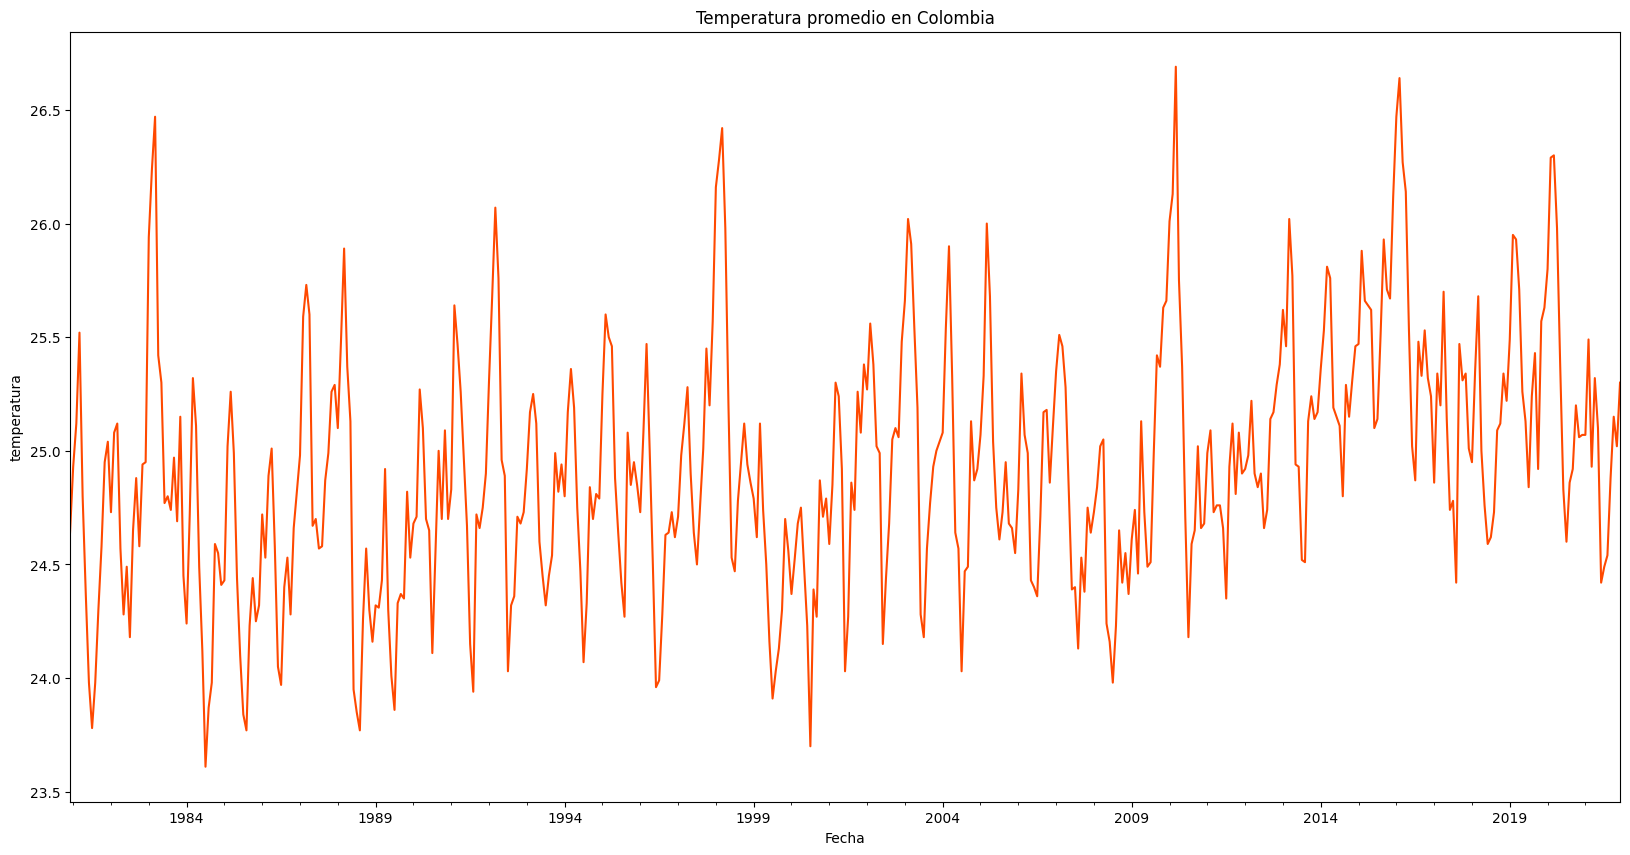

In [11]:
temperaturas.plot(figsize = (20,10), 
    title = 'Temperatura promedio en Colombia', color = '#FF4900', 
    xlabel = 'Fecha', ylabel = 'temperatura', legend = False) 

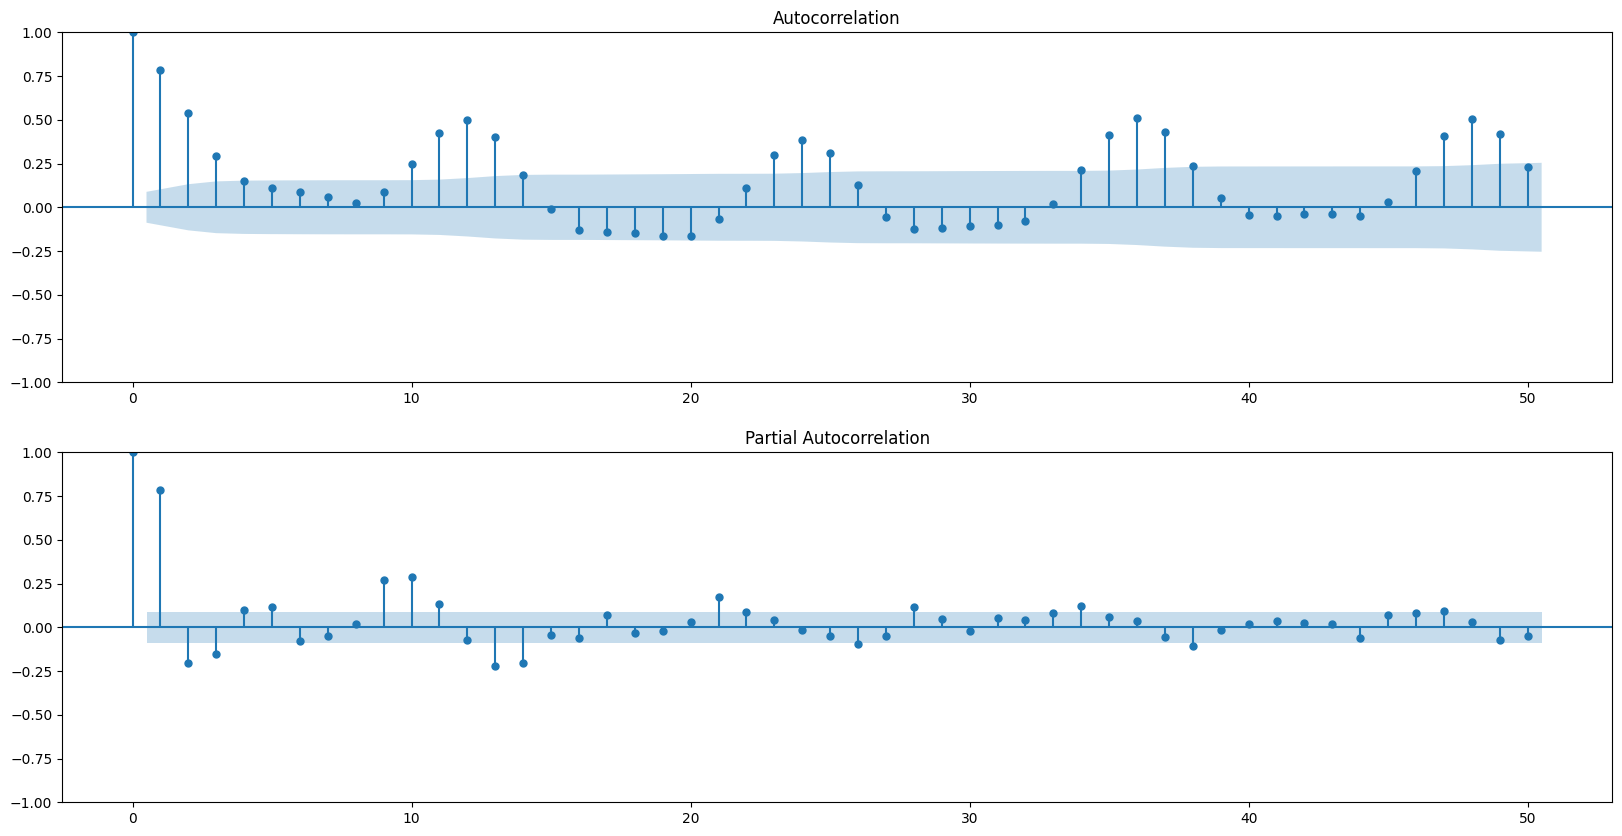

In [12]:
figure, axis = plt.subplots(2,1)
figure.set_size_inches(20,10)

plot_acf(temperaturas, ax=axis[0], lags=50);
plot_pacf(temperaturas, ax=axis[1], method = 'ywm', lags=50);

## Ajuste de modelo

In [13]:
modelo = pm.auto_arima(temperaturas, start_p=2, d=None, start_q=2, max_p=5, 
    max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2,
    max_D=1, max_Q=2, max_order=5, m=12, seasonal=True, stationary=False)

In [16]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  493
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 -37.468
Date:                              Mon, 14 Nov 2022   AIC                             90.937
Time:                                      22:46:25   BIC                            124.525
Sample:                                  12-01-1980   HQIC                           104.126
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -6.64e-07   1.85e-05     -0.036      0.971    -3.7e-05    3.57e-05
ar.L1          0.0339      0.123      0.275      0.783      -0.208       0.276
ar.L2          0.6132      0.086      7.143      0.000       0.445       0.781
ma.L1         -0.3693      0.134     -2.753      0.006      -0.632      -0.106
ma.L2         -0.5991      0.128     -4.685      0.000      -0.850      -0.348
ar.S.L12       0.9905      0.006    171.588      0.000       0.979       1.002
ma.S.L12      -0.8728      0.036    -24.206      0.000      -0.943      -0.802
sigma2         0.0639      0.004     15.266      0.000       0.056       0.072
===================================================================================
Ljung-Box (L1) (Q):                   2.75   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.10   Prob(JB):                         0.88
Heteroskedasticity (H):               0.99   Skew:                            -0.03
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

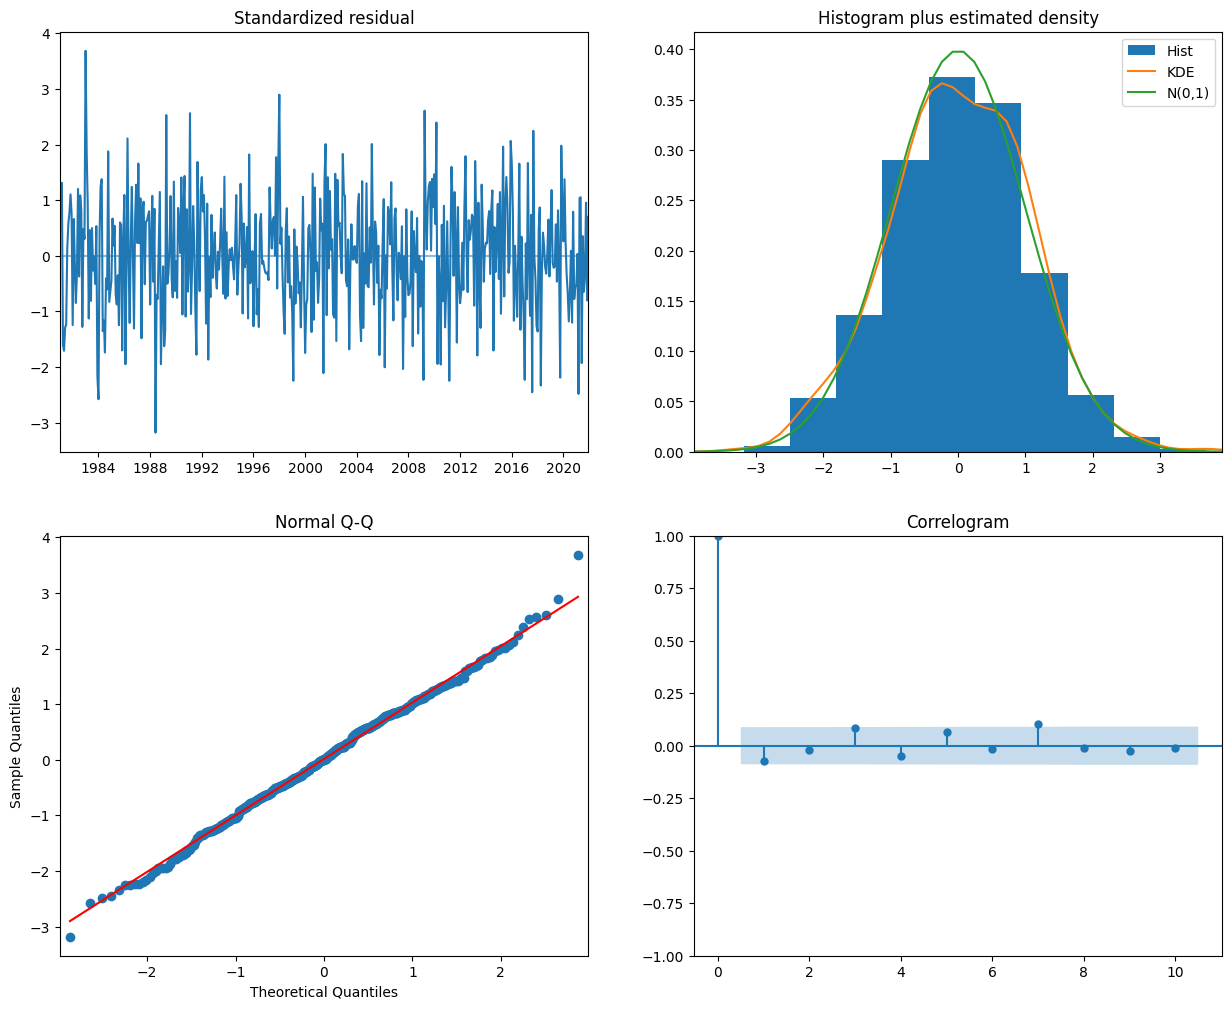

In [17]:
from statsmodels.tsa.arima.model import ARIMA
modelo.plot_diagnostics(figsize=(15, 12))
plt.show()

## Realización y validación de predicciones

## Conclusiones y recomendaciones